In [258]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go

from datetime import datetime, timedelta

from typing import Tuple

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import jarque_bera

## Auxilary functions ##

In [259]:
def pcaWeights(cov: np.ndarray, riskDist: np.ndarray = None,
               riskTarget: float = 1.) -> np.ndarray:
    eVal, eVec = np.linalg.eigh(cov)
    indices = eVal.argsort()[::-1]
    eVal, eVec = eVal[indices], eVec[:, indices]    # sorting by decreasing eVal (i.e. decreasing variance)
    if riskDist is None:
        riskDist = np.zeros(cov.shape[0])
        riskdist[-1] = 1.
    loads = riskTarget * (riskDist / eVal) ** 0.5
    weights = np.dot(eVec, np.reshape(loads, (-1, 1)))
    return weights

In [260]:
# symmetrical CUSUM filter
def getTEvents(gRaw: pd.Series, h: float) -> np.ndarray:
    gRaw = gRaw[~gRaw.index.duplicated(keep='first')]
    tEvents, sPos, sNeg = [], 0, 0
    diff = gRaw.diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos + diff.loc[i]), min(0, sNeg + diff.loc[i])
        if sNeg < -h:
            sNeg = 0
            tEvents.append(i)
        elif sPos > h:
            sPos = 0
            tEvents.append(i)
    return pd.DatetimeIndex(tEvents)

In [261]:
# based on https://towardsdatascience.com/advanced-candlesticks-for-machine-learning-i-tick-bars-a8b93728b4c5
def get_tick_bars(prices: np.ndarray, vols: np.ndarray,
                  times: np.ndarray, freq: int) -> np.ndarray:
    bars = np.zeros(shape=(len(range(freq, len(prices), freq)), 6), dtype=object)
    ind = 0
    for i in range(freq, len(prices), freq):
        bars[ind][0] = pd.Timestamp(times[i - 1])          # time
        bars[ind][1] = prices[i - freq]                    # open
        bars[ind][2] = np.max(prices[i - freq: i])         # high
        bars[ind][3] = np.min(prices[i - freq: i])         # low
        bars[ind][4] = prices[i - 1]                       # close
        bars[ind][5] = np.sum(vols[i - freq: i])           # volume
        ind += 1
    return bars

In [262]:
def get_volume_bars(prices: np.ndarray, vols: np.ndarray,
                    times: np.ndarray, bar_vol: int) -> np.ndarray:
    bars = np.zeros(shape=(len(prices), 6), dtype=object)
    ind = 0
    last_tick = 0
    cur_volume = 0
    for i in range(len(prices)):
        cur_volume += vols[i]
        if cur_volume >= bar_vol:
            bars[ind][0] = pd.Timestamp(times[i - 1])            # time
            bars[ind][1] = prices[last_tick]                     # open
            bars[ind][2] = np.max(prices[last_tick: i + 1])      # high
            bars[ind][3] = np.min(prices[last_tick: i + 1])      # low
            bars[ind][4] = prices[i]                             # close
            bars[ind][5] = np.sum(vols[last_tick: i + 1])        # volume
            cur_volume = 0
            last_tick = i + 1
            ind += 1
    return bars[:ind]

In [263]:
def get_dollar_bars(prices: np.ndarray, vols: np.ndarray,
                    times: np.ndarray, bar_sum: int) -> np.ndarray:
    bars = np.zeros(shape=(len(prices), 6), dtype=object)
    ind = 0
    last_tick = 0
    cur_sum = 0
    for i in range(len(prices)):
        cur_sum += vols[i] * prices[i]
        if cur_sum >= bar_sum:
            bars[ind][0] = pd.Timestamp(times[i - 1])            # time
            bars[ind][1] = prices[last_tick]                     # open
            bars[ind][2] = np.max(prices[last_tick: i + 1])      # high
            bars[ind][3] = np.min(prices[last_tick: i + 1])      # low
            bars[ind][4] = prices[i]                             # close
            bars[ind][5] = np.sum(vols[last_tick: i + 1])        # volume
            cur_sum = 0
            last_tick = i + 1
            ind += 1
    return bars[:ind]

In [265]:
def get_bollinger_bands(dollar_bars: np.ndarray, alpha: float) -> np.ndarray:
    prices = dollar_bars[:, 4]    # taking close prices
    ma = (pd.Series(prices).rolling(20, min_periods=20).mean())      # 20 bars moving average
    sigma = pd.Series(prices).rolling(20, min_periods=20).std()
    b_upper, b_lower = (ma + alpha * sigma), (ma - alpha * sigma)    # bollinger bounds    
    return np.array([ma, b_upper, b_lower])

## Exercises

For the following exercises I use S&P 500 futures tick data taken from https://www.kaggle.com/datasets/finnhub/sp-500-futures-tick-data-sp. I leave only the 2019 trades.

In [266]:
data = pd.read_csv('SP.csv')
data['datetime'] = data['date'] + "/" + data['time']
data['datetime'] = data['datetime'].apply(lambda dt: datetime.strptime(dt, '%m/%d/%Y/%H:%M:%S.%f'))
data.head()

,date,time,price,volume,datetime
0,01/03/2000,08:30:34.000,1496.4,0,2000-01-03 08:30:34
1,01/03/2000,08:30:36.000,1496.0,0,2000-01-03 08:30:36
2,01/03/2000,08:30:37.000,1495.5,0,2000-01-03 08:30:37
3,01/03/2000,08:30:46.000,1495.0,0,2000-01-03 08:30:46
4,01/03/2000,08:30:53.000,1495.5,0,2000-01-03 08:30:53


In [267]:
data = data[data['datetime'] >= datetime(2019, 1, 1)]
data.drop(['date', 'time'], axis=1, inplace=True)
data = data[data['volume'] > 0]
data.reset_index(inplace=True)
data.head()

,index,price,volume,datetime
0,13784918,2511.4,1,2019-01-01 17:01:44.013
1,13784919,2514.2,1,2019-01-01 17:02:40.684
2,13784920,2514.7,1,2019-01-01 17:02:40.794
3,13784921,2517.0,1,2019-01-01 17:02:51.397
4,13784922,2513.9,1,2019-01-01 17:06:32.898


In [268]:
data.to_csv('sp2019_clean.csv')

### 1. Tick, Volume, and Dollar Bars

In [269]:
# 10 trades per bar
tick_bars = get_tick_bars(data['price'].values, data['volume'].values, data['datetime'].values, 10)
fig = go.Figure(
    data=[go.Candlestick(x=tick_bars[:, 0], open=tick_bars[:, 1],
                                     high=tick_bars[:, 2], low=tick_bars[:, 3], close=tick_bars[:, 4])]
).update_layout(xaxis_title="Time", yaxis_title="Price", title="Tick Bars")
fig.show()

In [270]:
# 30 contracts per bar
volume_bars = get_volume_bars(data['price'].values, data['volume'].values, data['datetime'].values, 30)
fig = go.Figure(
    data=[go.Candlestick(x=volume_bars[:, 0], open=volume_bars[:, 1],
                         high=volume_bars[:, 2], low=volume_bars[:, 3], close=volume_bars[:, 4])]
).update_layout(xaxis_title="Time", yaxis_title="Price", title="Volume Bars")
fig.show()

In [271]:
# $30,000 per bar
dollar_bars = get_dollar_bars(data['price'].values, data['volume'].values, data['datetime'].values, 30000)
fig = go.Figure(
    data=[go.Candlestick(x=dollar_bars[:, 0], open=dollar_bars[:, 1],
                         high=dollar_bars[:, 2], low=dollar_bars[:, 3], close=dollar_bars[:, 4])]
).update_layout(xaxis_title="Time", yaxis_title="Price", title="Dollar Bars")
fig.show()

### 2. Analysis

Let's get the dynamics of weekly number of bars for the 3 types we obtained above.

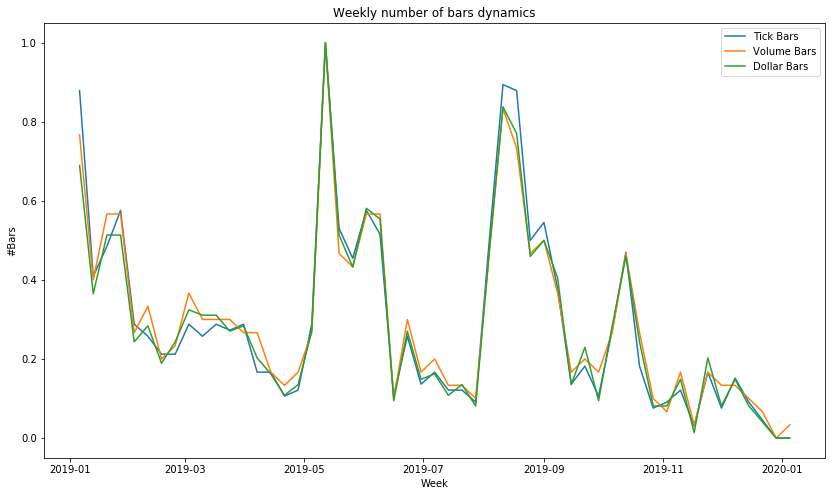

In [272]:
def get_num_week_bars(bars: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    df = pd.DataFrame(bars)
    df = df.groupby(pd.Grouper(key=0, freq="1W")).count()
    weeks = df.index
    scaler = MinMaxScaler()
    num_bars_scaled = scaler.fit_transform(df)[:, 0]
    return weeks, num_bars_scaled

fig = plt.figure(figsize=(14, 8))
for bars, name in [(tick_bars, 'Tick Bars'), (volume_bars, 'Volume Bars'), (dollar_bars, 'Dollar Bars')]:
    weeks, num_bars = get_num_week_bars(bars)
    plt.plot(weeks, num_bars, label=name)
plt.xlabel('Week')
plt.ylabel('#Bars')
plt.title('Weekly number of bars dynamics')
plt.legend()
plt.show()

It wouldn't be correct to compare 3 types of bars by simply looking at this graph as thresholds (#trades per bar, etc.) were chosen somewhat arbitrary, though dynamics for all 3 types look very similar. Now let's see which type of bars has the most stable dynamics:

In [273]:
for bars, name in [(tick_bars, 'Tick Bars'), (volume_bars, 'Volume Bars'), (dollar_bars, 'Dollar Bars')]:
    _, num_bars = get_num_week_bars(bars)
    print(f'{name} std: {np.std(num_bars)}')

Tick Bars std: 0.23769587232784958
Volume Bars std: 0.21539204819366545
Dollar Bars std: 0.21907803889958952


Now let's calculate serial correlations of rates of return:

In [274]:
def get_rates_of_return(bars: np.ndarray) -> np.ndarray:
    close_prices = pd.Series(bars[:, 4], index=bars[:, 0])
    return (close_prices.diff() / close_prices)[1:, ].astype(float)

tick_rr, volume_rr, dollar_rr = get_rates_of_return(tick_bars), \
                                get_rates_of_return(volume_bars), get_rates_of_return(dollar_bars)
for rr, name in [(tick_rr, 'Tick Bars'), (volume_rr, 'Volume Bars'), (dollar_rr, 'Dollar Bars')]:
    print(f'{name} autocorrelation: {rr.autocorr()}')

Tick Bars autocorrelation: 0.0051060357296840355
Volume Bars autocorrelation: -0.03959186492398938
Dollar Bars autocorrelation: 0.010364572063542365


Rate of returns variance by month & variance of variances:

In [275]:
def get_rr_variance_by_month(rr: np.ndarray) -> np.ndarray:
    return rr.groupby(pd.Grouper(freq="1M")).std()

for rr, name in [(tick_rr, 'Tick Bars'), (volume_rr, 'Volume Bars'), (dollar_rr, 'Dollar Bars')]:
    print(f'{name} variance of variances: {get_rr_variance_by_month(rr).std()}')

Tick Bars variance of variances: 0.0008520406436032977
Volume Bars variance of variances: 0.0015214014762862371
Dollar Bars variance of variances: 0.0007905080785010544


Jarque–Bera test (the closer to 0, the more the distribution looks like normal):

In [276]:
for rr, name in [(tick_rr, 'Tick Bars'), (volume_rr, 'Volume Bars'), (dollar_rr, 'Dollar Bars')]:
    print(f'{name} JB statistic: {jarque_bera(rr)[0]}')

Tick Bars JB statistic: 1792.4529305288654
Volume Bars JB statistic: 460.9929610113143
Dollar Bars JB statistic: 3031.4210077039847


### 3. Bollinger Bands

In [277]:
ma, b_upper, b_lower = get_bollinger_bands(dollar_bars, 1)
fig = go.Figure(
    data=[go.Candlestick(x=dollar_bars[:, 0], open=dollar_bars[:, 1],
                         high=dollar_bars[:, 2], low=dollar_bars[:, 3], close=dollar_bars[:, 4], name='Dollar Bars')]
).update_layout(xaxis_title="Time", yaxis_title="Price", title="Dollar Bars with Bollinger Bands")
fig.add_trace(go.Scatter(x=dollar_bars[:, 0], y=ma, line=dict(color="blue", width=1), name='MA'))
fig.add_trace(go.Scatter(x=dollar_bars[:, 0], y=b_upper, line=dict(color="orange", width=1), name='Upper Band'))
fig.add_trace(go.Scatter(x=dollar_bars[:, 0], y=b_lower, line=dict(color="orange", width=1), name='Lower Band'))
fig.show()

Let's count total number of bars that intersect Bollinger bands from inside to outside (i.e. price is shifting from the interval):

In [278]:
def get_num_intersect(dollar_bars: np.ndarray, b_upper: np.ndarray,
                      b_lower: np.ndarray) -> np.ndarray:
    num_intersect = 0
    for i, bar in enumerate(dollar_bars):
        if (bar[1] < b_upper[i] and bar[4] > b_upper[i]) or (bar[1] > b_lower[i] and bar[4] < b_lower[i]):
            num_intersect += 1
    return num_intersect

print(f'Total number of intersections: {get_num_intersect(dollar_bars, b_upper, b_lower)}')

Total number of intersections: 147


### 4. CUSUM Filter

Here I apply CUSUM filter to dollar bars absolute returns to get selected timestamps. Here I plot only closing graph instead of usual candlestick so that it is easier to see the timestmps selected by the filter.

In [279]:
def get_abs_returns(bars: np.ndarray) -> np.ndarray:
    close_prices = pd.Series(bars[:, 4], index=bars[:, 0])
    return np.abs(close_prices.diff().astype(float))

dollar_rabs = get_abs_returns(dollar_bars)
events = getTEvents(dollar_rabs, h=20)
chosen_bars_df = pd.DataFrame(dollar_bars).set_index(0).loc[events, :]

fig = go.Figure(
    go.Scatter(x=dollar_bars[:, 0], y=dollar_bars[:, 4], line=dict(color="blue", width=1), name='Close Price')
).update_layout(xaxis_title="Time", yaxis_title="Price", title="Close Price and Selected Timestamps")
fig.add_trace(go.Scatter(
    x=chosen_bars_df.index, y=chosen_bars_df[4], mode='markers', marker=dict(size=3), name='Selected Timestamps'
    )
)
fig.show()

You can notice that in general the filter chooses timestamps before more or less sharp price movements, though it's not always true.